# 07 - 1

In [1]:
from tensorflow import keras
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [2]:
train_input.shape, train_target.shape

((60000, 28, 28), (60000,))

In [3]:
test_input.shape, test_target.shape

((10000, 28, 28), (10000,))

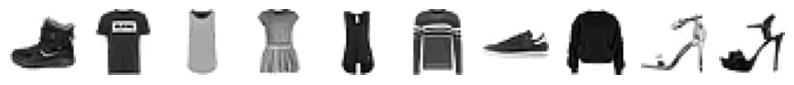

In [4]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 10, figsize=(10,10))
for i in range(10):
    axs[i].imshow(train_input[i], cmap='gray_r')
    axs[i].axis('off')
plt.show()

In [5]:
[train_target[i] for i in range(10)]

[9, 0, 0, 3, 0, 2, 7, 2, 5, 5]

In [6]:
import numpy as np
np.unique(train_target, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))

In [ ]:
## 로지스틱 회귀로 패션 아이템 분류하기

In [7]:
# 이 데이터의 경우 각 픽셀은 0~255 사이의 정수라서 보통 255로 나누어 0~1 사이의 값으로 정규화함
# reshape의 두 번째 매개변수를 28 * 28 로 하면 데이터의 두 번째, 세 번째 차원이 1차원으로 합쳐짐
train_scaled = train_input / 255.0
train_scaled = train_scaled.reshape(-1, 28*28)

In [8]:
train_scaled.shape

(60000, 784)

In [9]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import SGDClassifier
sc = SGDClassifier(loss='log_loss', max_iter=5, random_state=42)
scores = cross_validate(sc, train_scaled, train_target, n_jobs=-1)
np.mean(scores['test_score'])

0.8196000000000001

In [10]:
# 로지스틱 회귀로는 높은 점수를 얻지 못한다
# 그러니까 인공 신경망을 만들어 성능을 높일 수 있는지 확인해보자

In [11]:
## 인공 신경망

In [12]:
# 클래스가 총 10개이므로 z1 ~ z10 : 출력층
# z 값을 계산하는 단위를 뉴런 혹은 유닛 : 선형 계산이 전부임
# 픽셀 1,2를 x1, x2로 픽셀이 총 784개이므로 x784까지 있음 : 입력층

In [13]:
# 가장 인기가 많은 딥러닝 라이브러리인 텐서플로를 사용해 인공 신경망을 만들거임
# 케라는 텐서플로의 고수준 API임 : GPU를 사용함

In [14]:
from tensorflow import keras

In [15]:
## 인공 신경망으로 모델 만들기

In [16]:
from sklearn.model_selection import train_test_split
train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target, test_size=0.2, random_state=42)

In [17]:
# 딥러닝 분야의 데이터셋은 충분히 크기 때문에 검증 점수가 안정적이고, 교차 검증을 수행하기에는 훈련 시간이 너무 오래걸리기에 교차 검증을 사용하지 않고 검증 세트를 별도로 덜어내어 사용함

In [18]:
train_scaled.shape, train_target.shape

((48000, 784), (48000,))

In [19]:
val_scaled.shape, val_target.shape

((12000, 784), (12000,))

In [20]:
# 출력층을 먼저 구성할 것이고 이 중 가장 기본이 되는 층은 밀집층임 입력층 784개가 전부 하나의 출력층으로 밀집되어있기 때문 또한 양쪽이 뉴런이 모두 연결하고 있기에 완전 연결층이라고도 부름

In [21]:
# 케라스의 Dense 클래스를 사용해 밀집층을 만들거고, 필요한 매개변수는 뉴런 개수, 뉴런의 출력에 적용할 함수, 입력의 크기임
dense = keras.layers.Dense(10, activation='softmax',input_shape=(784,))
# 다중 분류이므로 시그모이드가 아닌 소프트맥스를 사용, 이진 분류면 시그모이드 사용

In [22]:
# 만들어진 밀집층으로 신경망 모델 작성, 케라스의 Sequential 클래스 사용
model = keras.Sequential(dense)

In [23]:
## 인공 신경망으로 패션 아이템 분류하기

In [24]:
# 케라스 모델은 훈련하기 전, compile()메서드를 통해 설정 단계를 거쳐야함. 여기서 손실 함수는 꼭 지정해야함
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
# 다중 분류에서는 크로스 엔트로피 손실 함수를 사용하는데 각각 밑과 같음
# 이진 분류 : binary_crossentropy
# 다중 분류 : categorical_crossentropy

In [25]:
# 원-핫 인코딩 : 타깃값을 해당 클래스만 1이고 나머지는 모두 0인 배열로 만드는 것
# 예를 들어 샘플이 티셔츠일 경우 첫 번쨰 뉴런의 활성화 함수 출력인 a1에 크로스 엔트로피 손실 함수를 적용하고 나머지를 전부 0을 곱해 0으로 만듬
# 그리고 손실을 낮추기 위해서 a1의 값을 가능한 1에 가깝게 만드는 것
# 그럼 한 번 패션 MNIST의 타깃값을 살펴보자
train_target[:10]

array([7, 3, 5, 8, 6, 9, 3, 3, 9, 9], dtype=uint8)

In [26]:
# 타깃값이 모두 정수일 때는 굳이 원-핫 인코딩을 사용하지 않고 바로 크로스 엔트로피 손실을 계산하는 것이 sparse_categorical_crossentropy임
# 원-핫 인코딩을 사용하려면 손실 함수를 loss='categorical_crossentropy'로 지정하면 됨

In [27]:
# 두 번째 매개변수인 metrics에서 accuracy는 정확도 지표를 보여주기 위해 사용한 것

In [28]:
# 모델 훈련 시작
model.fit(train_scaled, train_target, epochs = 5)

Epoch 1/5
1500/1500 [==============================] - 5s 2ms/step - loss: 0.6115 - accuracy: 0.7911
Epoch 2/5
1500/1500 [==============================] - 4s 3ms/step - loss: 0.4738 - accuracy: 0.8389
Epoch 3/5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.4499 - accuracy: 0.8475
Epoch 4/5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.4376 - accuracy: 0.8507
Epoch 5/5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.4294 - accuracy: 0.8557


In [31]:
# 이제 앞서 떼어놓은 검증 세트를 사용하여 모델의 성능을 확인할 거임
# 케라스에서는 evaluate() 메서드를 사용해서 성능을 확인함
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 3ms/step - loss: 0.4359 - accuracy: 0.8514


[0.43592655658721924, 0.8514166474342346]

# 07 - 2

In [32]:
## 2개의 층

In [33]:
# 인공 신경망 모델에 층을 2개 추가할 것임
# 기존에 했던 것과 다른 점은 입력층과 출력층 사이에 밀집층이 추가되는 것인데 이 둘 사이에 있는 모든 밀집층을 은닉층이라고 부름
# 은닉층에는 시그모이드와 소프트맥스를 사용하는 출력층과 다르게 비교적 자유로운 활성화 함수 사용가능하며 대표적인게 시그모이드와 렐루 함수임
dense1 = keras.layers.Dense(100, activation='sigmoid', input_shape=(784,))
dense2 = keras.layers.Dense(10, activation='softmax')
# dense1은 시그모이드 함수를 적용한 은닉층이고 dense2는 출력층임, 은닉층의 뉴런 개수를 정하는데는 특별한 기준은 없으나 적어도 출력층보다는 많이 만들어야함

In [34]:
## 심층 신경망 만들기

In [35]:
model = keras.Sequential([dense1, dense2])
# 여러 개의 층을 추가하려면 리스트 형식으로 만들어서 전달하며 출력층을 가장 마지막에 두어야함

In [36]:
# 케라스의 summary() 메서드로 정보를 얻을 수 있음
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 100)               78500     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79510 (310.59 KB)
Trainable params: 79510 (310.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [38]:
# 은닉층의 첫번째 입력 픽셀 784개와 지정해 준 뉴런 개수 100개에 절편이 따로 100개가 추가되므로 출력되는 모델 파라미터의 개수는 784 * 100 + 100으로 78500개
# 출력층은 출력 뉴런의 개수가 10개고 은닉층에서 784개의 픽셀이 100개로 압축되었기에 100 * 10 + 10으로 1010개임

In [39]:
## 층을 추가하는 다른 방법

In [42]:
# 앞에서는 객체(dense1, dense2)를 만들어서 직접 전달했지만 일반적으로는 두 객체를 따로 저장해서 쓸 일이 없기에 Sequential의 생성자에서 바로 객체를 생성함
model = keras.Sequential([keras.layers.Dense(100, activation='sigmoid', input_shape=(784,), name='hidden'),
                          keras.layers.Dense(10, activation='softmax', name='output')], name='패션 NMIST 모델')

In [43]:
model.summary()

Model: "패션 NMIST 모델"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden (Dense)              (None, 100)               78500     
                                                                 
 output (Dense)              (None, 10)                1010      
                                                                 
Total params: 79510 (310.59 KB)
Trainable params: 79510 (310.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [44]:
# 하지만 이 경우에는 층이 많아지면 생성자가 너무 길어지며 따로 층을 추가할 수도 없기에 일반적으로 층을 추가할때는 모델의 add() 메서드를 사용함
model = keras.Sequential()
model.add(keras.layers.Dense(100, activation='sigmoid', input_shape=(784,)))
model.add(keras.layers.Dense(10, activation='softmax'))

In [45]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 100)               78500     
                                                                 
 dense_4 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79510 (310.59 KB)
Trainable params: 79510 (310.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [46]:
# 모델 훈련
model.compile(loss='sparse_categorical_crossentropy',metrics='accuracy')
model.fit(train_scaled, train_target, epochs=5)

Epoch 1/5
1500/1500 [==============================] - 5s 3ms/step - loss: 0.5707 - accuracy: 0.8065
Epoch 2/5
1500/1500 [==============================] - 4s 2ms/step - loss: 0.4131 - accuracy: 0.8522
Epoch 3/5
1500/1500 [==============================] - 4s 2ms/step - loss: 0.3786 - accuracy: 0.8632
Epoch 4/5
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3557 - accuracy: 0.8702
Epoch 5/5
1500/1500 [==============================] - 4s 2ms/step - loss: 0.3384 - accuracy: 0.8779


In [47]:
# 추가된 층 덕분에 성능이 향상되었음!

In [48]:
## 렐루 함수

In [49]:
# 이미지 분류 문제에서 높은 성능을 보임
# 양수를 받으면 입력을 통과시키고 음수를 받으면 0으로 만듬

In [50]:
# 데이터가 28 * 28 크기이기 때문에 reshape을 사용하여 1차원으로 펼쳤지만, 케라스에서는 Flatten이라는 층을 추가해 펼칠 수 있음
# Flatten은 활성화 함수가 있는 것은 아니고 그냥 펼쳐주는 역할만 하기 때문에 신경망의 깊이에는 포함되지 않음
model = keras.Sequential()
model.add(keras.layers.Flatten(input_shape=(28,28)))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))

In [51]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_5 (Dense)             (None, 100)               78500     
                                                                 
 dense_6 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79510 (310.59 KB)
Trainable params: 79510 (310.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [52]:
# reshape 없이 Flatten을 이용해서 모델 훈련 해보자
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()
train_scaled = train_input / 255.0
train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target, test_size=0.2, random_state=42)

In [54]:
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
model.fit(train_scaled, train_target, epochs = 5)

Epoch 1/5
1500/1500 [==============================] - 5s 3ms/step - loss: 0.5298 - accuracy: 0.8143
Epoch 2/5
1500/1500 [==============================] - 4s 2ms/step - loss: 0.3957 - accuracy: 0.8580
Epoch 3/5
1500/1500 [==============================] - 4s 2ms/step - loss: 0.3571 - accuracy: 0.8727
Epoch 4/5
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3341 - accuracy: 0.8806
Epoch 5/5
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3183 - accuracy: 0.8868


In [55]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 3ms/step - loss: 0.3619 - accuracy: 0.8750


[0.36191853880882263, 0.875]

In [56]:
## 옵티마이저

In [57]:
# 신경망의 하이퍼파라미터 : 추가할 은닉층의 개수, 은닉층의 뉴런 개수, 층의 종류 등
# 케라스는 기본적으로 미니배치 경사 하강법을 사용하고 미니배치의 개수는 32개, fit() 메서드에서 batch_size 매개변수를 통해 조정가능, 마찬가지로 epochs 역시 하이퍼파라미터
# compile() 메서드에서는 케라스의 기본 경사 하강법 알고리즘은 RMSprop을 사용하는데 케라스에서는 다양한 종류의 경사 하강법 알고리즘을 제공하며, 이를 옵티마이저라고 부름
# 또한 RMSprop의 학습률 역시도 하이퍼파라미터임
# 여기서는 여러가지 옵티마이저를 테스트 해보겠음

In [58]:
# 확률적 경사 하강법 = SGD
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics='accuracy')

In [59]:
# 이미 tensorflow.keras.potimizers에 구현되어 있어서
# sgd = keras.optimizers.SGD()를 생략 가능
# 만약 학습률을 바꾸고 싶다면
sgd = keras.optimizers.SGD(learning_rate=0.1)
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics='accuracy')
# 같은 식으로 조정 가능

In [60]:
# 옵티마이저에는
# 기본 경사 하강법 옵티마이저 : SGD, => 모멘텀(momentum), 네스테로프 모멘텀(nesterov), Adam
# 적응적 학습률 옵티마이저 : RMSprop, => Adam / Adagrad

In [63]:
# 기본 경사 하강법 옵티마이저는 모두 SGD 클래스에서 제공
# 모멘텀 매개변수의 기본값은 0 이며 이를 더 큰 값으로 지정하면 모멘턴 최적화를 사용하고 일반적으로 모멘텀 매개변수는 0.9 이상을 지정함
# 네스테로프 매개변수의 기본값이 False를 True로 바꾸면 네스테로프 모멘텀 최적화를 사용 => 모멘텀 최적화를 2번 반복하며 대부분 기본 확률적 경사 하강법보다 성능이 좋음
sgd = keras.optimizers.SGD(momentum=0.9, nesterov= True)

In [64]:
# 모델이 최적점에 가까워질수록 학습률을 낮출 수 있는데 이런 학습률을 적응적 학습률이라고 함
# 대표적인게 RMSprop과 Adagrad 고 optimizer 매개변수의 기본값이 RMSprop임
adagrad = keras.optimizers.Adagrad()
model.compile(optimizer=adagrad, loss='sparse_categorical_crossentropy', metrics='accuracy')
# 혹은
rmsprop = keras.optimizers.RMSprop()
model.compile(optimizer=rmsprop, loss='sparse_categorical_crossentropy', metrics='accuracy')

In [65]:
# 모멘텀 최적화와 RMSprop의 장점을 접목한 것이 Adam이며 이를 이용해 모델을 훈련시켜보겠음
model = keras.Sequential()
model.add(keras.layers.Flatten(input_shape=(28,28)))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))

In [66]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
model.fit(train_scaled, train_target, epochs = 5)

Epoch 1/5
1500/1500 [==============================] - 5s 3ms/step - loss: 0.5296 - accuracy: 0.8152
Epoch 2/5
1500/1500 [==============================] - 4s 2ms/step - loss: 0.3960 - accuracy: 0.8588
Epoch 3/5
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3557 - accuracy: 0.8711
Epoch 4/5
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3308 - accuracy: 0.8788
Epoch 5/5
1500/1500 [==============================] - 4s 2ms/step - loss: 0.3101 - accuracy: 0.8861


In [67]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.3453 - accuracy: 0.8751


[0.3453311622142792, 0.875083327293396]

# 07 - 3